In [366]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from scipy.stats import variation
from sklearn import dummy
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics
from scipy.stats import variation
import shap
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score

seed=42

# Sommaire

## - I/ Sélection du modèle d'algorithme
    # A/ Variable "SiteEnergyUseWN(kBtu)"
        # A-1/ Algorithme LinearRegression
        # A-2/ Algorithme LinearSVR
        # A-3/ Algorithme RandomForestRegressor
        # A-4/ Algorithme XGBoost
    # B/ Variable "SiteEUIWN(kBtu/sf)"
        # B-1/ Algorithme LinearRegression
        # B-2/ Algorithme LinearSVR
        # B-3/ Algorithme RandomForestRegressor
        # B-4/ Algorithme XGBoost
    # C/ Variable "TotalGHGEmissions"
        # C-1/ Algorithme LinearRegression
        # C-2/ Algorithme LinearSVR
        # C-3/ Algorithme RandomForestRegressor
        # C-4/ Algorithme XGBoost
    # D/ Variable "GHGEmissionsIntensity"
        # D-1/ Algorithme LinearRegression
        # D-2/ Algorithme LinearSVR
        # D-3/ Algorithme RandomForestRegressor
        # D-4/ Algorithme XGBoost
## - II/ Feature Engineering
    #II-1/ Logarithme
    #II-2/ Normalisation
    #II-3/ Encodage
## - III/ Prédiction de "SiteEnergyUseWN(kBtu)"
    #III-1/ Algorithme XGBoost

In [367]:
data_prepro = pd.read_csv("data_nettoye.csv", sep=",",index_col="OSEBuildingID")

data_prepro.head()

,BuildingType,PrimaryPropertyType,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity,Neighborhood,Building_Age,Distance,NumberofFloors,NumberofBuildings,PropertyGFATotal
OSEBuildingID,,,,,,,,,,,,,
1,NonResidential,Hotel,60.0,7456910.0,84.300003,249.98,2.83,DOWNTOWN,89,0.24,12,1,88434.0
2,NonResidential,Hotel,61.0,8664479.0,97.900002,295.86,2.86,DOWNTOWN,20,0.23,11,1,103566.0
3,NonResidential,Hotel,43.0,73937112.0,97.699997,2089.28,2.19,DOWNTOWN,47,0.11,41,1,956110.0
5,NonResidential,Hotel,56.0,6946800.5,113.300003,286.43,4.67,DOWNTOWN,90,0.00,10,1,61320.0
8,NonResidential,Hotel,75.0,14656503.0,118.699997,505.01,2.88,DOWNTOWN,36,0.29,18,1,175580.0


In [368]:
data_prepro.isna().sum()

BuildingType             0
PrimaryPropertyType      0
ENERGYSTARScore          0
SiteEnergyUseWN(kBtu)    0
SiteEUIWN(kBtu/sf)       0
TotalGHGEmissions        0
GHGEmissionsIntensity    0
Neighborhood             0
Building_Age             0
Distance                 0
NumberofFloors           0
NumberofBuildings        0
PropertyGFATotal         0
dtype: int64

# I/ Feature Engineering
Logarithme, Encodage et Normalisation

## I-1/ Logarithme

Préparation des données avant de les envoyer dans un modèle, elle est faite suivant plusieurs étapes :

- Valeurs manquantes : voir notebook "Mazzi_Saïd_1_notebook_exploratoire_072022"
- Données asymétriques : traitées par une étape de transformation logarithmique et une étape de normalisation
- Données nominales catégorielles : traitées ici par OneHotEncoder

On va passer au Logarithme les données numériques et encoder avec OneHotEncoder, les données catégorielles.

In [369]:
num_columns = data_prepro.select_dtypes(['int64','float64']).columns

In [370]:
num_columns

Index(['ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Building_Age',
       'Distance', 'NumberofFloors', 'NumberofBuildings', 'PropertyGFATotal'],
      dtype='object')

In [371]:
var_log=['Distance','ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)','TotalGHGEmissions', 'SiteEUIWN(kBtu/sf)','GHGEmissionsIntensity',
         'Building_Age','NumberofFloors', 'PropertyGFATotal','NumberofBuildings']
var_cat=["PrimaryPropertyType","Neighborhood","BuildingType"]
var_norm=['Distance''Building_Age','NumberofFloors', 'PropertyGFATotal',
          'NumberofBuildings']

In [372]:
data_prepro

,BuildingType,PrimaryPropertyType,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity,Neighborhood,Building_Age,Distance,NumberofFloors,NumberofBuildings,PropertyGFATotal
OSEBuildingID,,,,,,,,,,,,,
1,NonResidential,Hotel,60.0,7.456910e+06,84.300003,249.98,2.83,DOWNTOWN,89,0.24,12,1,88434.0
2,NonResidential,Hotel,61.0,8.664479e+06,97.900002,295.86,2.86,DOWNTOWN,20,0.23,11,1,103566.0
3,NonResidential,Hotel,43.0,7.393711e+07,97.699997,2089.28,2.19,DOWNTOWN,47,0.11,41,1,956110.0
5,NonResidential,Hotel,56.0,6.946800e+06,113.300003,286.43,4.67,DOWNTOWN,90,0.00,10,1,61320.0
8,NonResidential,Hotel,75.0,1.465650e+07,118.699997,505.01,2.88,DOWNTOWN,36,0.29,18,1,175580.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50221,Nonresidential COS,Other,71.0,1.025432e+06,56.200001,20.33,1.11,DELRIDGE NEIGHBORHOODS,34,8.64,1,1,18261.0
50223,Nonresidential COS,Other,71.0,1.053706e+06,65.900002,32.17,2.01,DOWNTOWN,12,2.24,1,1,16000.0
50224,Nonresidential COS,Other,71.0,6.053764e+06,460.100006,223.54,16.99,MAGNOLIA / QUEEN ANNE,42,2.95,1,1,13157.0


In [373]:
data_log= data_prepro[var_log].apply(lambda x: np.log1p(x))

In [374]:
data_log.isnull().sum()

Distance                 0
ENERGYSTARScore          0
SiteEnergyUseWN(kBtu)    0
TotalGHGEmissions        0
SiteEUIWN(kBtu/sf)       0
GHGEmissionsIntensity    0
Building_Age             0
NumberofFloors           0
PropertyGFATotal         0
NumberofBuildings        0
dtype: int64

## I-2/ Normalisation
- On standarise les données;
- On va sélectionner nos variables numériques et on enlève les variables de prédiction;

In [375]:
col_num = data_prepro.select_dtypes(['int64','float64']).columns
col_num

Index(['ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Building_Age',
       'Distance', 'NumberofFloors', 'NumberofBuildings', 'PropertyGFATotal'],
      dtype='object')

La normalisation permet aux données d'avoir le même ordre de grandeur. On transforme la distribution des données de façon à avoir la moyenne à 0 et l'écart type à 1.

In [376]:
data_prepro[col_num] = StandardScaler().fit_transform(data_prepro[col_num])

In [377]:
data_prepro[col_num].isnull().sum()

ENERGYSTARScore          0
SiteEnergyUseWN(kBtu)    0
SiteEUIWN(kBtu/sf)       0
TotalGHGEmissions        0
GHGEmissionsIntensity    0
Building_Age             0
Distance                 0
NumberofFloors           0
NumberofBuildings        0
PropertyGFATotal         0
dtype: int64

In [378]:
def verif_normalisation(df):
      for col in df :
        data_col=df[col]
        moyenne=np.mean(data_col)
        ecartType = np.std(data_col)

        print("Mesures statistiques pour la variable {}" .format(col))
        print("La moyenne est de : {} ".format(round(abs(moyenne), 2)))
        print("L'écart type est de : {} ".format(round(abs(ecartType), 2)))
        print(" ")
        print(" ")

In [379]:
verif_normalisation(data_prepro[col_num])

Mesures statistiques pour la variable ENERGYSTARScore
La moyenne est de : 0.0 
L'écart type est de : 1.0 
 
 
Mesures statistiques pour la variable SiteEnergyUseWN(kBtu)
La moyenne est de : 0.0 
L'écart type est de : 1.0 
 
 
Mesures statistiques pour la variable SiteEUIWN(kBtu/sf)
La moyenne est de : 0.0 
L'écart type est de : 1.0 
 
 
Mesures statistiques pour la variable TotalGHGEmissions
La moyenne est de : 0.0 
L'écart type est de : 1.0 
 
 
Mesures statistiques pour la variable GHGEmissionsIntensity
La moyenne est de : 0.0 
L'écart type est de : 1.0 
 
 
Mesures statistiques pour la variable Building_Age
La moyenne est de : 0.0 
L'écart type est de : 1.0 
 
 
Mesures statistiques pour la variable Distance
La moyenne est de : 0.0 
L'écart type est de : 1.0 
 
 
Mesures statistiques pour la variable NumberofFloors
La moyenne est de : 0.0 
L'écart type est de : 1.0 
 
 
Mesures statistiques pour la variable NumberofBuildings
La moyenne est de : 0.0 
L'écart type est de : 1.0 
 
 
Me

--> Nos données numériques ont bien été normalisées car elles ont toutes une moyenne de 0 et un écart type de 1.

## I-3/ Encodage

Pour certains modèles de machine learning tels que les régressions, seule l'analyse de données numériques est acceptée. Pour utiliser ces modèles avec mes données catégorielles, il faut donc transformer les variables catégorielles en nombres avant d'appliquer des modèles de machine learning.

One-Hot encoding : consiste à diviser une variable catégorielle en N variables où chaque nouvelle variable correspond à une modalité prise par la variable catégorielle. Chaque variable créée est codée en 0 ou 1 selon la présence ou l'absence de cette modalité pour la ligne.

In [380]:
col_cat = data_prepro.select_dtypes(['object']).columns

In [381]:
data_prepro[col_cat].head()

,BuildingType,PrimaryPropertyType,Neighborhood
OSEBuildingID,,,
1,NonResidential,Hotel,DOWNTOWN
2,NonResidential,Hotel,DOWNTOWN
3,NonResidential,Hotel,DOWNTOWN
5,NonResidential,Hotel,DOWNTOWN
8,NonResidential,Hotel,DOWNTOWN


In [382]:
data_prepro["PrimaryPropertyType"].unique().shape

(20,)

In [383]:
data_prepro["Neighborhood"].unique().shape

(19,)

In [384]:
data_prepro["BuildingType"].unique().shape

(5,)

In [385]:
data_prepro.shape

(1501, 13)

In [386]:
data_prepro[col_num]

,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity,Building_Age,Distance,NumberofFloors,NumberofBuildings,PropertyGFATotal
OSEBuildingID,,,,,,,,,,
1,-0.259891,-0.046699,0.078156,0.083391,0.468464,1.065586,-1.217047,1.148926,-0.089713,-0.130754
2,-0.217439,0.005657,0.255133,0.145566,0.480779,-1.056387,-1.219976,1.001265,-0.089713,-0.053570
3,-0.981585,2.835632,0.252531,2.575937,0.205728,-0.226050,-1.255125,5.431108,-0.089713,4.294963
5,-0.429702,-0.068815,0.455534,0.132787,1.223830,1.096339,-1.287345,0.853603,-0.089713,-0.269053
8,0.376898,0.265448,0.525804,0.428997,0.488990,-0.564335,-1.202402,2.034895,-0.089713,0.313748
...,...,...,...,...,...,...,...,...,...,...
50221,0.207087,-0.325544,-0.287510,-0.227821,-0.237640,-0.625842,1.243368,-0.475350,-0.089713,-0.488682
50223,0.207087,-0.324318,-0.161284,-0.211776,0.131833,-1.302413,-0.631234,-0.475350,-0.089713,-0.500214
50224,0.207087,-0.107534,4.968453,0.047561,6.281500,-0.379816,-0.423270,-0.475350,-0.089713,-0.514716


In [387]:
#Encodage avec Dummy
#data_ohe = pd.get_dummies(data_prepro[col_cat])
#data_ohe.shape

Encodage avec OneHotEncoder

In [388]:
#création d'une instance one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#effectuer un one-hot encoding sur les colonnes 'col_cat'
data_ohe = pd.DataFrame(encoder.fit_transform(data_prepro[col_cat]).toarray())

encoder.get_feature_names(["BuildingType","PrimaryPropertyType","Neighborhood"])
data_ohe.columns = encoder.get_feature_names(["BuildingType","PrimaryPropertyType","Neighborhood"])
#merge les colonnes one-hot encoded avec le DataFrame d'origine
data_mod = pd.merge(data_prepro[col_num].reset_index(), data_ohe, left_index = True, right_index = True)
#data_mod  = data_prepro[col_num].join(data_ohe)

data_mod

,OSEBuildingID,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity,Building_Age,Distance,NumberofFloors,NumberofBuildings,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,1,-0.259891,-0.046699,0.078156,0.083391,0.468464,1.065586,-1.217047,1.148926,-0.089713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,-0.217439,0.005657,0.255133,0.145566,0.480779,-1.056387,-1.219976,1.001265,-0.089713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,-0.981585,2.835632,0.252531,2.575937,0.205728,-0.226050,-1.255125,5.431108,-0.089713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,-0.429702,-0.068815,0.455534,0.132787,1.223830,1.096339,-1.287345,0.853603,-0.089713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.376898,0.265448,0.525804,0.428997,0.488990,-0.564335,-1.202402,2.034895,-0.089713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,50221,0.207087,-0.325544,-0.287510,-0.227821,-0.237640,-0.625842,1.243368,-0.475350,-0.089713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1497,50223,0.207087,-0.324318,-0.161284,-0.211776,0.131833,-1.302413,-0.631234,-0.475350,-0.089713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,50224,0.207087,-0.107534,4.968453,0.047561,6.281500,-0.379816,-0.423270,-0.475350,-0.089713,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1499,50225,0.207087,-0.336062,-0.296619,-0.225409,-0.048798,-0.841114,1.518700,-0.475350,-0.089713,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [389]:
data_mod.columns

Index(['OSEBuildingID', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)',
       'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'Building_Age', 'Distance', 'NumberofFloors', 'NumberofBuildings',
       'PropertyGFATotal', 'BuildingType_Campus',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'BuildingType_Nonresidential WA', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility'

In [390]:
data_mod.shape

(1501, 55)

In [391]:
data_prepro[col_num].shape

(1501, 10)

In [392]:
data_ohe.shape

(1501, 44)

In [393]:
data_ohe.isna().mean().sum()

0.0

In [394]:
data_mod.isna().mean().sum()

0.0

# II/ Sélection du modèle d'algorithme

## Analyse entre 4 algorithmes de regression (Linaire et non linéaire)

On va appliquer 4 algorithmes de regression (sans optimisation des hyperparamètres) aux variables d'émissions de CO2 et de consommations d'énergies (4 variables sélectionnées) et on va garder l'algorithme de regression qui donne les meilleurs scores pour l'appliquer aux prédictions.

### A/ Variable 'SiteEnergyUseWN(kBtu)'

- Séparation du jeu d'entrainement et du jeu de test

In [395]:
X = data_mod.copy()
y = X['SiteEnergyUseWN(kBtu)']

X = X.drop(['SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)','TotalGHGEmissions', 
            'GHGEmissionsIntensity'],axis=1)

X = X[X.columns]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                      test_size=0.2 # 20% des données dans le jeu de test
                                      , random_state=42)

In [396]:
X_train.columns

Index(['OSEBuildingID', 'ENERGYSTARScore', 'Building_Age', 'Distance',
       'NumberofFloors', 'NumberofBuildings', 'PropertyGFATotal',
       'BuildingType_Campus', 'BuildingType_NonResidential',
       'BuildingType_Nonresidential COS', 'BuildingType_Nonresidential WA',
       'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Siz

In [397]:
y_train.head()

538    -0.128876
1217   -0.359951
1113   -0.268547
324    -0.318507
361    -0.261485
Name: SiteEnergyUseWN(kBtu), dtype: float64

In [398]:
lr = LinearRegression()
lsvr = LinearSVR(random_state=42, tol=1e-05)
clf = RandomForestRegressor(max_depth=2, random_state=42)
#xgb = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb = XGBRegressor(max_depth=2,random_state=42)

### A-1/ Algorithme LinearRegression

In [399]:
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lr_pred))

RMSE: 1.29
Coefficient of determination (R²): 0.18


Text(0, 0.5, 'Valeurs prédictes')

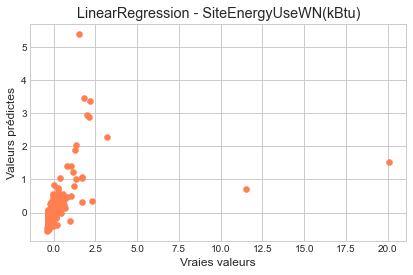

In [400]:
plt.title("LinearRegression - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test, y_lr_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### A-2/ Algorithme LinearSVR

In [401]:
lsvr.fit(X_train, y_train)
y_lsvr_pred = lsvr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lsvr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lsvr_pred))

RMSE: 6.76
Coefficient of determination (R²): -21.42


Liblinear failed to converge, increase the number of iterations.


Text(0, 0.5, 'Valeurs prédictes')

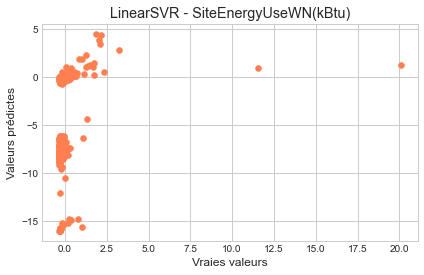

In [402]:
plt.title("LinearSVR - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test, y_lsvr_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### A-3/ Algorithme RandomForestRegressor 

In [403]:
clf.fit(X_train, y_train)
y_rdf_pred = clf.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_rdf_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_rdf_pred))

RMSE: 1.31
Coefficient of determination (R²): 0.15


Text(0, 0.5, 'Valeurs prédictes')

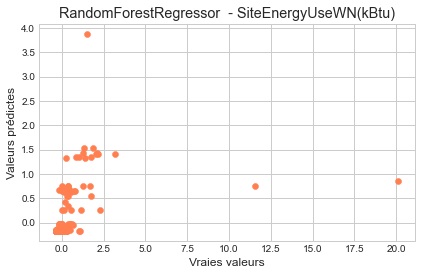

In [404]:
plt.title("RandomForestRegressor  - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test, y_rdf_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### A-4/ Algorithme XGBoost

In [405]:
xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_xgb_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_xgb_pred))

RMSE: 1.25
Coefficient of determination (R²): 0.23


Text(0, 0.5, 'Valeurs prédictes')

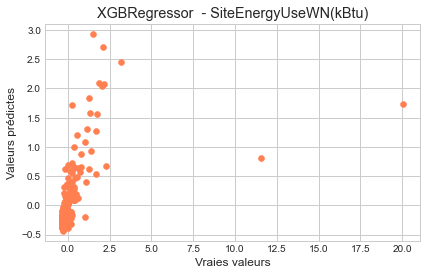

In [406]:
plt.title("XGBRegressor  - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test, y_xgb_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### B/ Variable 'SiteEUIWN(kBtu/sf)'

- Séparation du jeu d'entrainement et du jeu de test

In [407]:
X = data_mod.copy()
y = X['SiteEUIWN(kBtu/sf)']

X = X.drop(['SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)','TotalGHGEmissions', 
                        'GHGEmissionsIntensity'],axis=1)

X = X[X.columns]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                      test_size=0.2 # 20% des données dans le jeu de test
                                      , random_state=42)

### B-1/ Algorithme LinearRegression

In [408]:
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lr_pred))

RMSE: 0.91
Coefficient of determination (R²): 0.31


Text(0, 0.5, 'Valeurs prédictes')

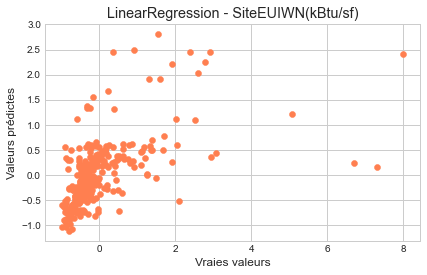

In [409]:
plt.title("LinearRegression - SiteEUIWN(kBtu/sf)")
plt.scatter(y_test, y_lr_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

###  B-2/ Algorithme LinearSVR

In [410]:
lsvr.fit(X_train, y_train)
y_lsvr_pred = lsvr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lsvr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lsvr_pred))

RMSE: 2.47
Coefficient of determination (R²): -4.11


Liblinear failed to converge, increase the number of iterations.


Text(0, 0.5, 'Valeurs prédictes')

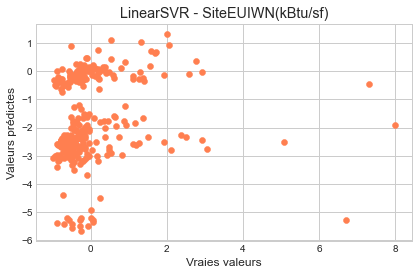

In [411]:
plt.title("LinearSVR - SiteEUIWN(kBtu/sf)")
plt.scatter(y_test, y_lsvr_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

###  B-3/ Algorithme RandomForestRegressor 

In [412]:
clf.fit(X_train, y_train)
y_rdf_pred = clf.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_rdf_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_rdf_pred))

RMSE: 1.01
Coefficient of determination (R²): 0.15


Text(0, 0.5, 'Valeurs prédictes')

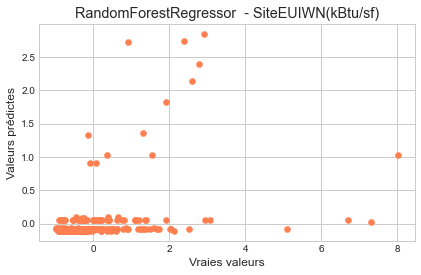

In [413]:
plt.title("RandomForestRegressor  - SiteEUIWN(kBtu/sf)")
plt.scatter(y_test, y_rdf_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

###  B-4/ Algorithme XGBoost

In [414]:
xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_xgb_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_xgb_pred))

RMSE: 0.79
Coefficient of determination (R²): 0.48


Text(0, 0.5, 'Valeurs prédictes')

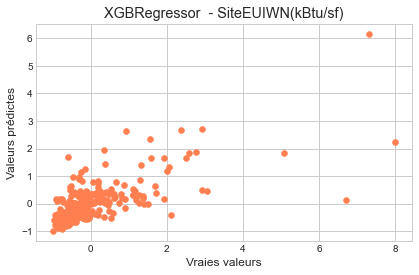

In [415]:
plt.title("XGBRegressor  - SiteEUIWN(kBtu/sf)")
plt.scatter(y_test, y_xgb_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### C/ Variable ''TotalGHGEmissions''

- Séparation du jeu d'entrainement et du jeu de test

In [416]:
X = data_mod.copy()
y = X['TotalGHGEmissions']

X = X.drop(['SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)','TotalGHGEmissions', 
                        'GHGEmissionsIntensity'],axis=1)

X = X[X.columns]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                      test_size=0.2 # 20% des données dans le jeu de test
                                      , random_state=42)

###  C-1/ Algorithme LinearRegression

In [417]:
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lr_pred))

RMSE: 1.32
Coefficient of determination (R²): 0.05


Text(0, 0.5, 'Valeurs prédictes')

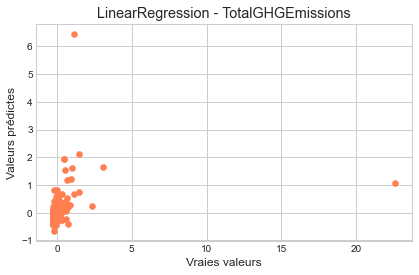

In [418]:
plt.title("LinearRegression - TotalGHGEmissions")
plt.scatter(y_test, y_lr_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### C-2/ Algorithme LinearSVR

In [419]:
lsvr.fit(X_train, y_train)
y_lsvr_pred = lsvr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lsvr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lsvr_pred))

RMSE: 18.13
Coefficient of determination (R²): -178.70


Liblinear failed to converge, increase the number of iterations.


Text(0, 0.5, 'Valeurs prédictes')

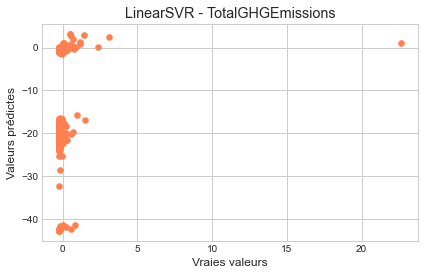

In [420]:
plt.title("LinearSVR - TotalGHGEmissions")
plt.scatter(y_test, y_lsvr_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### C-3/ Algorithme RandomForestRegressor 

In [421]:
clf.fit(X_train, y_train)
y_rdf_pred = clf.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_rdf_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_rdf_pred))

RMSE: 1.33
Coefficient of determination (R²): 0.03


Text(0, 0.5, 'Valeurs prédictes')

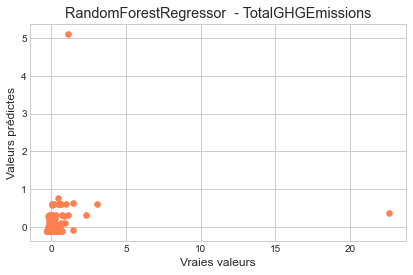

In [422]:
plt.title("RandomForestRegressor  - TotalGHGEmissions")
plt.scatter(y_test, y_rdf_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### C-4/ Algorithme XGBoost

In [423]:
xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_xgb_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_xgb_pred))

RMSE: 1.27
Coefficient of determination (R²): 0.11


Text(0, 0.5, 'Valeurs prédictes')

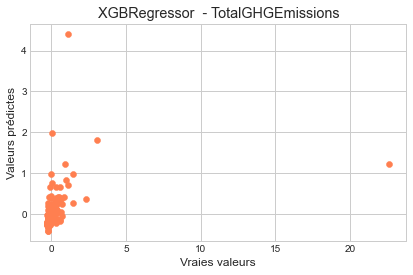

In [424]:
plt.title("XGBRegressor  - TotalGHGEmissions")
plt.scatter(y_test, y_xgb_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### D/ Variable ''GHGEmissionsIntensity''


- Séparation du jeu d'entrainement et du jeu de test

In [425]:
X = data_mod.copy()
y = X['GHGEmissionsIntensity']

X = X.drop(['SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)','TotalGHGEmissions', 
                        'GHGEmissionsIntensity'],axis=1)

X = X[X.columns]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                      test_size=0.2 # 20% des données dans le jeu de test
                                      , random_state=42)

### D-1/ Algorithme LinearRegression

In [426]:
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lr_pred))

RMSE: 1.15
Coefficient of determination (R²): 0.19


Text(0, 0.5, 'Valeurs prédictes')

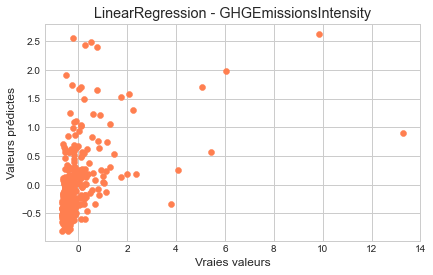

In [427]:
plt.title("LinearRegression - GHGEmissionsIntensity")
plt.scatter(y_test, y_lr_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### D-2/ Algorithme LinearSVR

In [428]:
lsvr.fit(X_train, y_train)
y_lsvr_pred = lsvr.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_lsvr_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_lsvr_pred))

RMSE: 23.53
Coefficient of determination (R²): -338.48


Liblinear failed to converge, increase the number of iterations.


Text(0, 0.5, 'Valeurs prédictes')

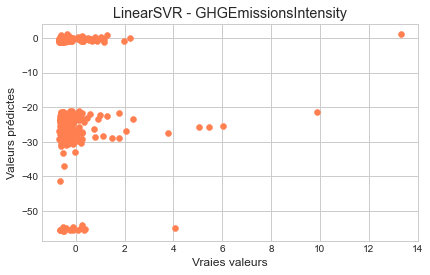

In [429]:
plt.title("LinearSVR - GHGEmissionsIntensity")
plt.scatter(y_test, y_lsvr_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### D-3/ Algorithme RandomForestRegressor 

In [430]:
clf.fit(X_train, y_train)
y_rdf_pred = clf.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_rdf_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_rdf_pred))

RMSE: 1.24
Coefficient of determination (R²): 0.05


Text(0, 0.5, 'Valeurs prédictes')

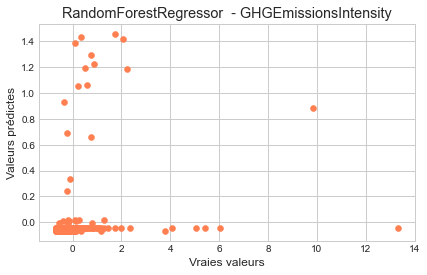

In [431]:
plt.title("RandomForestRegressor  - GHGEmissionsIntensity")
plt.scatter(y_test, y_rdf_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### D-4/ Algorithme XGBoost

In [432]:
xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_xgb_pred)))
print("Coefficient of determination (R²): %.2f"% r2_score(y_test, y_xgb_pred))

RMSE: 1.11
Coefficient of determination (R²): 0.25


Text(0, 0.5, 'Valeurs prédictes')

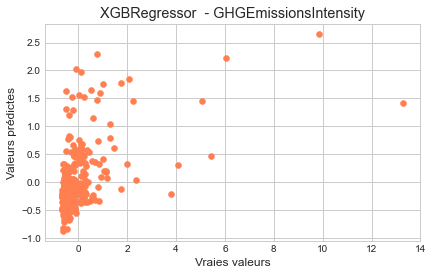

In [433]:
plt.title("XGBRegressor  - GHGEmissionsIntensity")
plt.scatter(y_test, y_xgb_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

In [441]:
#RMSE
df0 = pd.DataFrame(np.array([["","","",""],[1.29, 6.76, 1.31, 1.25], [0.91, 2.47, 1.01, 0.79], [1.32, 18.13, 1.33, 1.27],[1.15, 23.53, 1.24, 1.11]]),
                   index=["RMSE","SiteEnergyUseWN(kBtu)", "SiteEUIWN(kBtu/sf)", "TotalGHGEmissions", "GHGEmissionsIntensity"], 
                   columns=["LinearRegression", "LinearSVR", "RandomForestRegressor", "XGBoost"])
df0

,LinearRegression,LinearSVR,RandomForestRegressor,XGBoost
RMSE,,,,
SiteEnergyUseWN(kBtu),1.29,6.76,1.31,1.25
SiteEUIWN(kBtu/sf),0.91,2.47,1.01,0.79
TotalGHGEmissions,1.32,18.13,1.33,1.27
GHGEmissionsIntensity,1.15,23.53,1.24,1.11


In [442]:
#r2
df1 = pd.DataFrame(np.array([["","","",""],[0.18, -21.42, 0.15, 0.23], [0.31, -4.11, 0.15, 0.48], [0.05, -178.70, 0.03, 0.11],[0.19, -338.48, 0.05, 0.25]]),
                   index=["r2","SiteEnergyUseWN(kBtu)", "SiteEUIWN(kBtu/sf)", "TotalGHGEmissions", "GHGEmissionsIntensity"], 
                   columns=["LinearRegression", "LinearSVR", "RandomForestRegressor", "XGBoost"])
df1

,LinearRegression,LinearSVR,RandomForestRegressor,XGBoost
r2,,,,
SiteEnergyUseWN(kBtu),0.18,-21.42,0.15,0.23
SiteEUIWN(kBtu/sf),0.31,-4.11,0.15,0.48
TotalGHGEmissions,0.05,-178.7,0.03,0.11
GHGEmissionsIntensity,0.19,-338.48,0.05,0.25


In [454]:
#RMSE & r2
df2 = pd.DataFrame(np.array([["",""],[1.25, 0.23]]),
                   index=["XGBoost","SiteEnergyUseWN(kBtu)"], 
                   columns=["RMSE", "r2"])
print("Score avant gridSearchCV")
df2

Score avant gridSearchCV


,RMSE,r2
XGBoost,,
SiteEnergyUseWN(kBtu),1.25,0.23


In [460]:
#RMSE & r2
df8 = pd.DataFrame(np.array([["",""], [1.27, 0.11]]),
                   index=["XGBoost", "TotalGHGEmissions"], 
                   columns=["RMSE", "r2"])
print("Score avant gridSearchCV")
df8

Score avant gridSearchCV


,RMSE,r2
XGBoost,,
TotalGHGEmissions,1.27,0.11


In [448]:
#RMSE & r2
df3 = pd.DataFrame(np.array([["",""],[1.25, 0.23], [1.27, 0.03]]),
                   index=["XGBoost","SiteEnergyUseWN(kBtu)", "TotalGHGEmissions"], 
                   columns=["RMSE", "r2"])
df3

,RMSE,r2
XGBoost,,
SiteEnergyUseWN(kBtu),1.25,0.23
TotalGHGEmissions,1.27,0.03


## Choix du modèle d'algorithme et des variables de prédictions

### On constate que le modèle XGBoost donne le meilleur compromis de performance. En effet, il est meilleur en terme de score r2 et également meilleur en terme de score RMSE. On se basera pour la suite sur les 2 variables "SiteEnergyUseWN(kBtu)" et "TotalGHGEmissions" (Analyse Exploratoire) et on suprimera de notre dataset les variables "SiteEUIWN(kBtu/sf)" et "GHGEmissionsIntensity".

In [357]:
del data_mod["SiteEUIWN(kBtu/sf)"]
del data_mod["GHGEmissionsIntensity"]

In [358]:
#on va exporter notre dataset pour l'utiliser pour une autre prédiction dans un autre NotebBook
data_mod.to_csv("data_finalise.csv")

# III/ Prédiction de "SiteEnergyUseWN(kBtu)"

In [359]:
X_seuwn = data_mod.copy()
y_seuwn = X_seuwn['SiteEnergyUseWN(kBtu)']
X_seuwn = X_seuwn.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions'],axis=1)

X_seuwn = X_seuwn[X_seuwn.columns]

X_train_seuwn, X_test_seuwn, y_train_seuwn, y_test_seuwn = model_selection.train_test_split(X_seuwn, y_seuwn,
                                      test_size=0.2 # 20% des données dans le jeu de test
                                      , random_state=42)

print("La taille du jeu d'entrainement est de {} bâtiments.".format(X_train_seuwn.shape[0]))
print("La taille du jeu de test est de {} bâtiments.".format(X_test_seuwn.shape[0]))

La taille du jeu d'entrainement est de 1200 bâtiments.
La taille du jeu de test est de 301 bâtiments.


In [360]:
X_test_seuwn

,OSEBuildingID,ENERGYSTARScore,Building_Age,Distance,NumberofFloors,NumberofBuildings,PropertyGFATotal,BuildingType_Campus,BuildingType_NonResidential,BuildingType_Nonresidential COS,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
1117,24537,0.207087,-0.533582,1.603643,-0.475350,-0.089713,-0.411871,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
643,20182,0.928781,-0.318309,0.871376,-0.475350,-0.089713,-0.447341,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
422,654,-0.005176,-0.349062,0.285563,-0.475350,-0.089713,-0.293271,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,639,-2.127805,0.973326,-0.256314,-0.180027,-0.089713,-0.272766,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451,708,-0.132534,-0.748854,-0.792333,0.410619,-0.089713,0.833536,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,19873,-1.448564,0.942573,-1.014942,-0.327688,-0.089713,-0.447831,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1343,27205,1.141044,0.235249,1.753025,-0.475350,-0.089713,-0.366944,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
654,20377,1.353307,-0.595088,0.361719,-0.180027,-0.089713,-0.182066,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
619,19910,-0.641965,0.296755,-1.164324,-0.032366,-0.089713,-0.445790,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Hyperparamètres avec GridSearchCV des différents modèles
GridSearch est une approche de réglage des paramètres qui permettra d'évaluer méthodiquement un modèle pour chaque paramètres d'algorithme spécifiés dans une grille.

## III-1/ Algorithme XGBoost

C’est une méthode ensembliste qui fait partie de la famille des algorithmes de boosting qui se base sur les arbres de décision et qui utilise plus particulièrement le boosting de gradient.

Cet algorithme construit un modèle faible qui donne de très mauvais résultats, il tire des conclusions sur les erreurs qui existent entre la prédiction et la réalité. A partir de ces conclusions et des conditions prises lors de la création du premier arbre, il va construire un modèle plus solide en tentant de réduire l'erreur de prédiction du modèle précédent (prédiction des erreurs en donnant un poids élevé aux mauvaises prédictions de l'arbre précédent pour ne plus la refaire). Il s'agit ici d'un système itératif car la formation de l'arbre au temps T à besoin que l'arbre T-1 soit formé pour pouvoir prédire et améliorer les erreurs sur le modèle.

Hyperparamètre :
- n_estimators : nombre d'arbres de décision (nbre d'arbres séquentiels pour corriger les arbres précédents);
- max_depth : nombre maximum de niveaux dans chaque arbre de décision;
- learning_rate : Accroître le taux d'apprentissage (également appelé "eta") et réduit donc la pondération des variables pour éviter l'overfitting;
- gamma : Réduction minimale des pertes requise pour créer une partition supplémentaire sur un nœud feuille de l'arbre. Plus le gamma est grand, plus l'algorithme sera conservateur;
- min_child_weight: Nbre d'échantillon requis pour former un noeud (Profondeur maximale d'un arbre). L'augmentation de cette valeur rendra le modèle plus complexe et plus susceptible de sur-ajuster. 0 indique aucune limite de profondeur;

In [361]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from datetime import datetime
start_time = datetime.now()

# On fixe les valeurs des hyperparamètres à tester
param_grid = {'n_estimators':  [5, 100, 200],  
              'max_depth': [20,50,5],
              'learning_rate': [0.02, 0.05, 0.1],
              'gamma': [0.5, 1, 3],
            'min_child_weight': [1, 3, 5],
             }
                
# Choisir un score à optimiser
score = 'r2'

# define the model/ estimator
model = XGBRegressor(random_state=42, verbosity = 0) #verbosity = 0 : silent : les messages warning ne sont pas 
                                                #affichés.  (0 :"silent", 1:"warning", 2:"info", 3:"debug")
# On utilise GridSearchCV
xgbr= GridSearchCV(model, param_grid, scoring=score, cv=5)   

# On optimise sur le jeu d'entraînement
xgbr.fit(X_train_seuwn, y_train_seuwn)

# On généralise
y_xgbr_seuwn_pred = xgbr.predict(X_test_seuwn)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(xgbr.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement:")
print(xgbr.best_score_)
print(' ')

#RMSE
print("RMSE: %.3f" % np.sqrt(mean_squared_error(y_test_seuwn, y_xgbr_seuwn_pred)))
print(' ')
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        xgbr.cv_results_['mean_test_score'], # score moyen
        xgbr.cv_results_['std_test_score'],  # écart-type du score
        xgbr.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )
end_time = datetime.now()
print('Durée d\'exécution : {}'.format(end_time - start_time))

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}
 
Meilleur(s) score sur le jeu d'entraînement:
0.6812470741572514
 
RMSE: 1.282
 
Résultats de la validation croisée :
r2 = -0.227 (+/-0.250) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 5}
r2 = 0.583 (+/-0.333) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 100}
r2 = 0.628 (+/-0.429) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 200}
r2 = -0.229 (+/-0.248) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 5}
r2 = 0.578 (+/-0.304) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 100}
r2 = 0.634 (+/-0.329) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 

On a un r2 à 0.68 et RMSE à 1.28

In [456]:
#RMSE & r2
df5 = pd.DataFrame(np.array([["",""], [1.28, 0.68]]),
                   index=["XGBoost", "SiteEnergyUseWN(kBtu)"], 
                   columns=["RMSE", "r2"])
print("Score après gridSearchCV")
df5

Score après gridSearchCV


,RMSE,r2
XGBoost,,
SiteEnergyUseWN(kBtu),1.28,0.68


In [362]:
tab_xgbr_seuwn=pd.DataFrame({'Valeur réelle':y_test_seuwn, 'Valeur prédite':y_xgbr_seuwn_pred})
tab_xgbr_seuwn

,Valeur réelle,Valeur prédite
1117,-0.261627,-0.307445
643,-0.326783,-0.315238
422,-0.259841,-0.225777
413,-0.148560,-0.210038
451,0.181916,0.465916
...,...,...
610,-0.297700,-0.267000
1343,-0.288968,-0.284210
654,-0.222688,-0.181117
619,-0.298864,-0.277341


Text(0, 0.5, 'Valeurs prédictes')

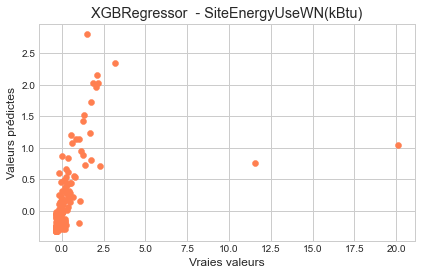

In [363]:
plt.title("XGBRegressor  - SiteEnergyUseWN(kBtu)")
plt.scatter(y_test_seuwn, y_xgbr_seuwn_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### Feature Importance
Regardons comment chaque variable à influencé le modèle XGBoost

Text(0.5, 0, 'Xgboost Feature Importance')

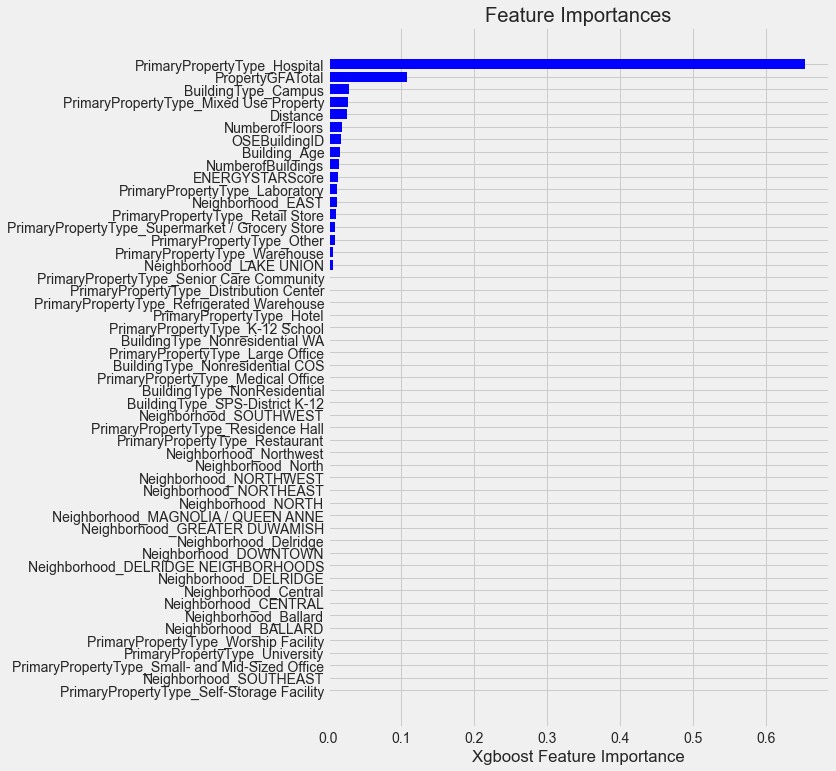

In [459]:
liste_variables=X_test_seuwn.columns
importances = xgbr.best_estimator_.feature_importances_
indices = np.argsort(importances)

# style du graphique 
plt.figure(figsize=(8,12))
plt.style.use('fivethirtyeight')
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel("Xgboost Feature Importance")


### On observe que si on veut avoir un modèle précis, on doit garder les 5 features suivants "PrimaryPropertyType", "PropertyGFATotal", "Building_Type", "Distance" et "NumberofFloors".